In [21]:
import os
import sys
import random
import cv2
import math
import re
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from xml.dom.minidom import parse
import xml.dom.minidom

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from sklearn.decomposition import PCA

from datetime import datetime
from PIL import Image
import visualize


In [2]:

class Config():
    TrainImageRoot = r'D:\datasets\choledoch_dataset'
    # TestImageRoot = r'D:\QT_Project\Save\danggui\test'

    SPLIT_SIGN = '\\'

    # 打印所有的全局参数
    def display(self):
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")

config = Config()
config.display()


Configurations:
SPLIT_SIGN                     \
TrainImageRoot                 D:\datasets\choledoch_dataset




# 1. Read the path of the dataset
what we need is:

- data path
- hdr path ps: (hdr+data) == full data
- rgb path
- annotation ps: when the data belongs to "L"

In [14]:

path = config.TrainImageRoot
# DatPath == hyperspectral data's path e.g. "D:\\datasets\\choledoch_dataset\\L\\L\\hyper\\041248-20x-roi6.raw"
DatPath = []
# HdrPath == hyperspectral hdr data path e.g. "D:\\datasets\\choledoch_dataset\\L\\L\\hyper\\041248_2-20x-roi1.hdr"
HdrPath = []
# Rgbpath == rgb images path e.g. "D:\\datasets\\choledoch_dataset\\L\\L\\rgb\\030406C_2-20x-roi3.jpg"
RgbPath = []
# annotation of each data e.g. "D:\\datasets\\choledoch_dataset\\L\\L\\annotation\\041248_2-20x-roi5.xml"
AnnotationPath = []


for root, dirs, files in os.walk(path):
    for file in files:
        if file.split('.')[-1] == 'hdr' and file.split('-')[-1].split('.')[-2] != 'blank':
            HdrPath.append(os.path.join(root, file))
        elif file.split('.')[-1] == 'raw' and file.split('-')[-1].split('.')[-2] != 'blank':
            DatPath.append(os.path.join(root, file))
        elif file.split('.')[-1] == 'jpg' and root.split(config.SPLIT_SIGN)[-4] != 'Choledoch_RGB':
            RgbPath.append(os.path.join(root, file))
        elif file.split('.')[-1] == 'xml' :
            AnnotationPath.append(os.path.join(root, file))

DatPath.sort()
HdrPath.sort()
RgbPath.sort()
AnnotationPath.sort()

# 2. Set some important function AND Visualize
- get_class
- get_rgb_img
- xml_2_gt


L


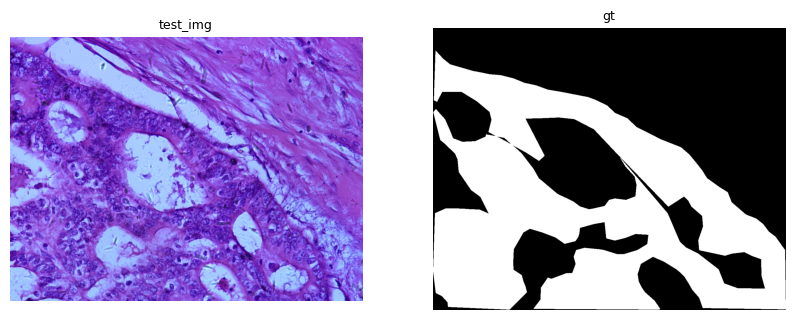

In [23]:
# Using the path of data to get class
def get_class(path):
    classes = path.split("\\")[-4]
    return classes

# Using the rgb path 2 get images
def get_rgb_img(rgb_path):
    img = Image.open(rgb_path)
    return img

# Using the xml to get annotation
def xml2gt(xml_path):
    # 使用minidom解析器打开 XML 文档
    DOMTree = xml.dom.minidom.parse(xml_path)
    collection = DOMTree.documentElement

    # 读取imgesize
    imagesize = collection.getElementsByTagName("imagesize")
    h = int(imagesize[0].childNodes[0].firstChild.data)
    w = int(imagesize[0].childNodes[1].firstChild.data)
    # 根据宽高创建初始GT
    gt = np.zeros([h,w])
    objects = collection.getElementsByTagName("object")
    for object in objects:
        # 获取第n个多边形
        polygons = object.getElementsByTagName("polygon")

        for polygon in polygons:
            pts = polygon.getElementsByTagName("pt")
            points = []
            for pt in pts:
                x = int(pt.childNodes[0].firstChild.data)
                y = int(pt.childNodes[1].firstChild.data)
                points.append([x,y])
            points = np.array(points)
            # 根据多边形的点向原始GT上绘制标签
            gt = cv2.fillPoly(gt, [points],color = [1])
        return gt

path = "D:\\datasets\\choledoch_dataset\\L\\L\\hyper\\041248-20x-roi6.raw"
print(get_class(path))

rgb_path = "D:\\datasets\\choledoch_dataset\\L\\L\\rgb\\041248-20x-roi6.jpg"
rgb = get_rgb_img(rgb_path)

annotation_path = "D:\\datasets\\choledoch_dataset\\L\\L\\annotation\\041248-20x-roi6.xml"
gt = xml2gt(annotation_path)

# now, we can visualize all these picture

visualize.display_images([rgb,gt],cols = 2,titles = ["test_img",'gt'],cmap = 'gray')